In [1]:
using DSP
using Distributions
using DataFrames
#using Plots
using PlotlyJS
using Random
using NonNegLeastSquares
using Base
using LinearAlgebra

In [129]:
abstract type SPEDistribution{T} end
struct ExponTruncNormalSPE{T}
    expon_rate::T
    norm_sigma::T
    norm_mu::T
    trunc_low::T
    expon_weight::T
end

make_spe_dist(d::SPEDistribution{T}) where T = error("not implemented")

function make_spe_dist(d::ExponTruncNormalSPE{T}) where T
    norm = Normal(d.norm_mu, d.norm_sigma)
    tnorm = truncated(norm, lower=d.trunc_low)

    expon = Exponential(d.expon_rate)
    dist = MixtureModel([expon, tnorm], [d.expon_weight, 1 - d.expon_weight])
        
    return dist

end

abstract type PulseShape{T} end
struct GumbelPulse{T} <: PulseShape{T}
    sigma::T
    amplitude::T
end

make_pulse_dist(p::T) where {T <:PulseShape} = error("not implemented")
make_pulse_dist(p::GumbelPulse{T}) where {T} = mu -> Gumbel(mu, p.sigma)

struct PMTWaveform{T}
    photon_times::AbstractVector{T}
    photon_charges::AbstractVector{T}
    pulse_shape::PulseShape{T}
end


function evaluate_waveform(times, wf::PMTWaveform{T}) where T
    pulse_dist = make_pulse_dist(wf.pulse_shape)
    
    evaluated_wf = zeros(T, size(times))

    for (ptime, pcharge) in zip(wf.photon_times, wf.photon_charges)
        evaluated_wf += pdf.(pulse_dist(ptime), times) .* pcharge .* wf.pulse_shape.amplitude
    end

    evaluated_wf

end

function add_gaussian_white_noise(values, scale)
    values .+ randn(size(values)) * scale
end


struct DigitizedWaveform{T}
    timestamps::AbstractVector{T}
    values::AbstractVector{T}
end


function digitize_waveform(
    true_waveform::PMTWaveform{T},
    sampling_frequency::T,
    digitizer_frequency::T,
    noise_amp::T,
    filter,
    eval_range::Tuple{T, T},
    ) where T
    
    dt = 1/sampling_frequency # ns
    timesteps = range(eval_range[1], eval_range[2], step=dt)

    waveform_values = evaluate_waveform(timesteps, true_waveform)
    waveform_values_noise = add_gaussian_white_noise(waveform_values, 0.1)

    waveform_filtered = filt(filter, waveform_values_noise)

    resampling_rate = digitizer_frequency / sampling_frequency
    new_interval = range(eval_range[1], eval_range[2], step=1/digitizer_frequency)
    waveform_resampled = resample(waveform_filtered, resampling_rate)

    new_interval, waveform_resampled
end
    





digitize_waveform (generic function with 1 method)

# SPE Distribution

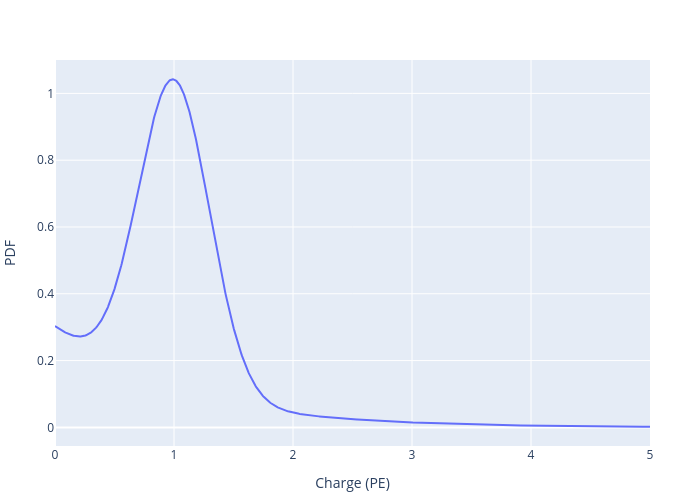

In [130]:
spe = ExponTruncNormalSPE(1., 0.3, 1., 0., 0.3)
spe_d = make_spe_dist(spe)

xs = collect(range(0, 5., 1000))

plot(xs, pdf.(spe_d, xs), Layout(yaxis_title="PDF", xaxis_title="Charge (PE)"))

# Pulse Shape

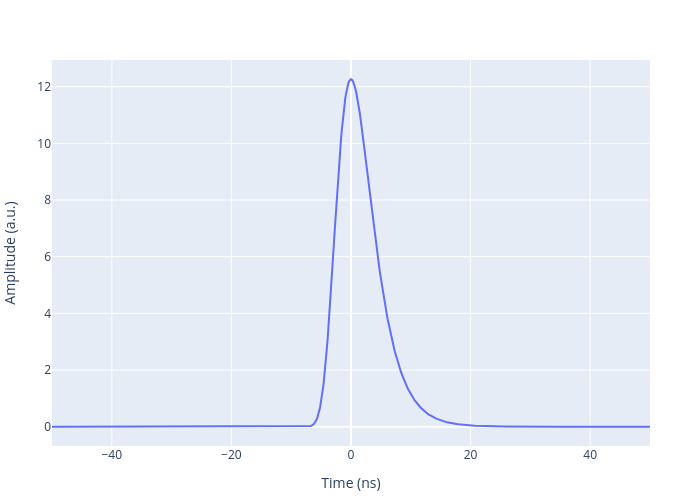

In [131]:
pulse_model = GumbelPulse(3., 100.)
pulse = make_pulse_dist(pulse_model)

xs = collect(range(-50., 50., 1000))
plot(xs, pdf.(pulse(0), xs) * pulse_model.amplitude, Layout(yaxis_title="Amplitude (a.u.)", xaxis_title="Time (ns)"))


In [132]:
Random.seed!(1337)
arrival_time_pdf = Gamma(2., 10.)
hit_times = [rand(arrival_time_pdf) for _ in 1:30]

spe = ExponTruncNormalSPE(1., 0.3, 1., 0., 0.3)
spe_d = make_spe_dist(spe)

charges = rand(spe_d, size(hit_times))

#wf_model = make_gumbel_waveform_model(hit_times)
wf = PMTWaveform(hit_times, charges, GumbelPulse(5., 100.))



PMTWaveform{Float64}([25.18086538762324, 24.312614896836582, 18.44286526466457, 21.621393950176557, 15.872437965786474, 24.68048492285893, 6.015017386304126, 40.4223696669964, 15.64730653850634, 52.30652264863582  …  39.80451983229149, 26.67976495495527, 20.966144812383455, 22.79396867272815, 46.256494569549815, 28.89596116601656, 66.31666744970983, 2.1738644743684183, 3.7085299239216485, 20.096355690482422], [0.7456782085657232, 1.571149576760134, 0.0025408792817845395, 1.1565538291867767, 1.0681203656558151, 1.3189978742001254, 0.9157682828285744, 1.992989762696298, 0.8556643532189029, 1.1739182666628467  …  1.013902132289012, 0.6281831486998877, 1.1978212198121208, 1.2938606086908813, 0.9850562419603436, 0.4183925759219871, 1.1532499851736535, 1.4319267005708778, 0.039209326936032005, 1.119518426086186], GumbelPulse{Float64}(5.0, 100.0))

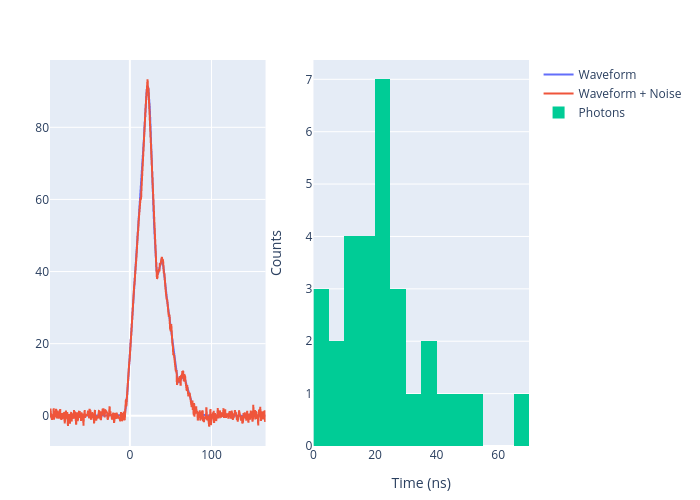

In [134]:
min_time, max_time = extrema(hit_times)

min_time -= 100
max_time += 100


sampling_frequency = 2. # GHz
dt = 1/sampling_frequency # ns
values = range(min_time, max_time, step=dt)

waveform_values = evaluate_waveform(values, wf)
waveform_values_noise = add_gaussian_white_noise(waveform_values, 1)


p1 = plot(
    [
        scatter(;x=collect(values), y=waveform_values, name="Waveform"),
            scatter(; x=collect(values), y=waveform_values_noise, name="Waveform + Noise")])
p2 = plot(histogram(x=hit_times, weights=charges, xbins_start=0, xbins_end=100, xbins_size=5, name="Photons"),
            Layout(xaxis_title="Time (ns)", yaxis_title="Counts"))
p = [p1 p2] 
p




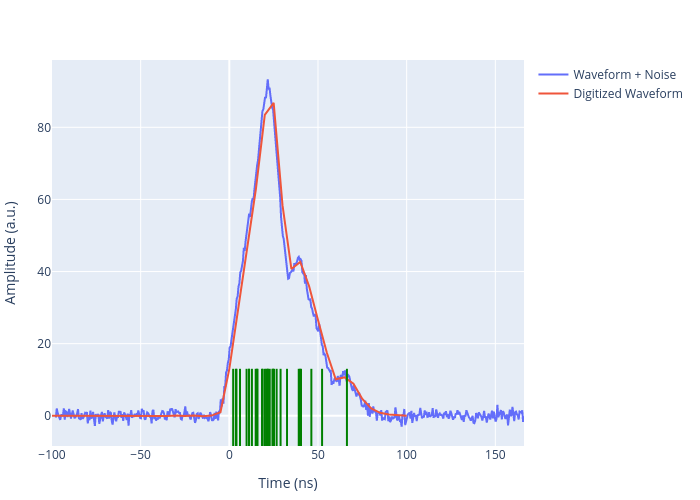

In [136]:
adc_freq = 200E-3 # GhZ
noise_amp = 0.05
sampling_frequency = 2. # Ghz

designmethod = Butterworth(1)
filter = digitalfilter(Lowpass(125E-3, fs=sampling_frequency), designmethod)


timestamps, digi_wf = digitize_waveform(
    wf,
    sampling_frequency,
    adc_freq,
    noise_amp,
    filter,
    (-100., 100.)
)


rugs = vline(wf.photon_times, 0, 0.2, yref="paper",
            line_color="green", name="Hits")

p1 = plot(
    [
        #scatter(;x=collect(values), y=waveform_values, name="Waveform"),
        scatter(; x=collect(values), y=waveform_values_noise, name="Waveform + Noise"),
        scatter(; x=timestamps, y=digi_wf, name="Digitized Waveform"),
        ],
    Layout(xaxis_title="Time (ns)", yaxis_title="Amplitude (a.u.)", shapes=rugs))

In [137]:
function make_nnls_matrix(
    pulse_times::AbstractVector{T},
    pulse_shape::PulseShape,
    timestamps::AbstractVector{T}) where {T}

    nnls_matrix = zeros(T, size(timestamps, 1), size(pulse_times, 1))

    for i in 1:size(pulse_times, 1)
        pulse = make_pulse_dist(pulse_shape)(pulse_times[i])
        nnls_matrix[:, i] = pulse_shape.amplitude .* pdf.(pulse, timestamps)
    end

    nnls_matrix
    
end


function apply_nnls(
    pulse_times::AbstractVector{T},
    pulse_shape::PulseShape{T},
    timestamps::AbstractVector{T},
    waveform::AbstractVector{T}) where {T}

    matrix = make_nnls_matrix(pulse_times, pulse_shape, timestamps)
    charges = nonneg_lsq(matrix, waveform; alg=:nnls)[:, 1]
end




apply_nnls (generic function with 1 method)

In [138]:
pulse_shape = GumbelPulse(5., 100.)

pulse_times = collect(range(min_time, max_time, step=2))
pulse_charges = apply_nnls(pulse_times, pulse_shape, timestamps, digi_wf)

nonzero = pulse_charges .> 0.1

reco_wf = PMTWaveform(pulse_times[nonzero], pulse_charges[nonzero], pulse_shape)


PMTWaveform{Float64}([4.173864474368415, 6.173864474368415, 14.173864474368415, 16.173864474368415, 22.173864474368415, 26.173864474368415, 28.173864474368415, 40.173864474368415, 42.173864474368415, 48.173864474368415, 54.173864474368415, 56.173864474368415, 66.17386447436841, 68.17386447436841], [1.3927542989872455, 2.541024856703465, 5.032779183436273, 1.064457958682356, 6.726491695404785, 1.8558068338537903, 2.666008889193781, 3.6443087081539645, 0.5517010093225788, 1.5336270945499235, 0.5538993338323045, 0.3012835662353657, 0.319932468103397, 0.8030924853666824], GumbelPulse{Float64}(5.0, 100.0))

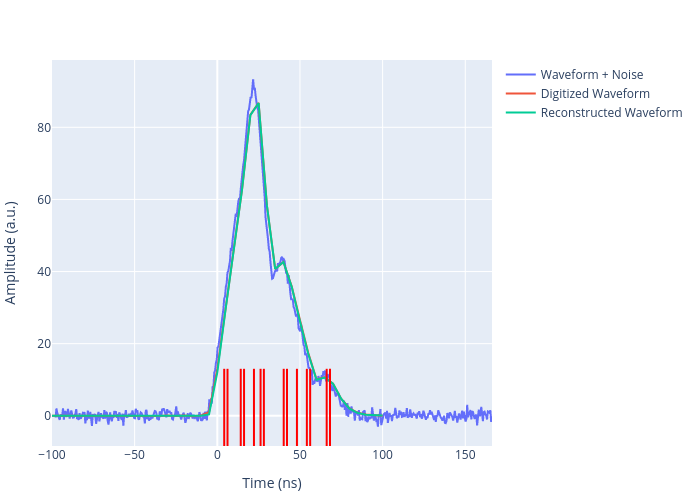

In [139]:
rugs = vline(wf.photon_times, 0, 0.2, yref="paper",
            line_color="green", name="Hits")


rugs = vline(reco_wf.photon_times, 0, 0.2, yref="paper",
line_color="red", name="Hits")


p1 = plot(
    [
        #scatter(;x=collect(values), y=waveform_values, name="Waveform"),
        scatter(; x=collect(values), y=waveform_values_noise, name="Waveform + Noise"),
        scatter(; x=timestamps, y=digi_wf, name="Digitized Waveform"),
        scatter(; x=timestamps, y=evaluate_waveform(timestamps, reco_wf), name="Reconstructed Waveform")
        ],
    Layout(xaxis_title="Time (ns)", yaxis_title="Amplitude (a.u.)", shapes=rugs))

In [140]:
pulse_charges[pulse_charges .> 0.1]

14-element Vector{Float64}:
 1.3927542989872455
 2.541024856703465
 5.032779183436273
 1.064457958682356
 6.726491695404785
 1.8558068338537903
 2.666008889193781
 3.6443087081539645
 0.5517010093225788
 1.5336270945499235
 0.5538993338323045
 0.3012835662353657
 0.319932468103397
 0.8030924853666824